In [47]:
from SymbolicDSGE import ModelParser, DSGESolver, Shock
from SymbolicDSGE.utils import FRED
from SymbolicDSGE.utils.math_utils import HP_two_sided, annualized_log_percent
from SymbolicDSGE.regression import (
    SymbolicRegressor,
    TemplateConfig,
    PySRParams,
    ModelParametrizer,
)

from sympy import Matrix, Symbol, print_latex, Rational
from warnings import catch_warnings, simplefilter

from numpy import array, float64, ceil, sqrt, log, std, random, isclose
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

# mpl.rcParams["figure.dpi"] = 300

## 1 | Model Setup via YAML

`SymbolicDSGE` uses a YAML based configuration to define DSGE models. Examples of configurations can be found in the `MODELS` directory.
Parsed models are represented as `ModelConfig` objects, which allow detailed inspection of the inferred model structure.
Confirming the model setup is read as intended is strongly recommended and easy to achieve.

All expressions read from the configuration are converted to `SymPy` objects of the appropriate type. (`Expr`, `Function`, `Symbol`, etc.)
The project treats all variables as functions of time, using a variable `t: sp.Symbol` and defining time shifts via `sp.Function` objects.
To stay consistent with said scheme, variables in the configuration must be defined as functions, e.g. `c(t)`, `k(t-1)`, etc.

__NOTES:__
- As of release `v0.1.0-alpha`, variable constraints are parsed but not enforced in the solver.
- The solver backend (`inearsolve`) does not support backward time shifts, therefore all model equations that refer to a lagged variable (e.g. `k(t-1)`) are shifted forward in time during parsing. For example `"x(t) = alpha*x(t-1) + eps(t)"` becomes `"x(t+1) = alpha*x(t) + eps(t+1)"` internally. The configuration does not require any modification to time indices.

In [48]:
model, kalman = ModelParser("MODELS/POST82.yaml").get_all()

with catch_warnings():
    # Equations in a sp.Matrix are deprecated, this is only used as a pretty print function
    simplefilter(action="ignore")
    mat = Matrix(model.equations.model)
mat

Matrix([
[                                    Eq(Pi(t), beta*Pi(t + 1) + kappa*(x(t) - z(t)))],
[                           Eq(x(t), -tau_inv*(-Pi(t + 1) + r(t)) + g(t) + x(t + 1))],
[Eq(r(t), e_r + rho_r*r(t - 1*1) + (1 - rho_r)*(psi_pi*Pi(t) + psi_x*(x(t) - z(t))))],
[                                                   Eq(g(t), e_g + rho_g*g(t - 1*1))],
[                                                   Eq(z(t), e_z + rho_z*z(t - 1*1))]])

## 2 | Solving the Model

The `DSGESolver` class provides methods to solve and simulate DSGE models defined via `ModelConfig` objects.
The solver is kept simple and lightweight with a focus on small/medium scale linear models.
The solver is completely numeric and does not suffer from the performance issues brought by symbolic computation.
On the backend, `DSGESolver` converts all relevant `SymPy` expressions to `NumPy` based lambdas for fast evaluation.

The solution process consists of two main steps:
1. **Compilation**: The model equations are compiled into a numeric representation suitable for solving. This step requires the user to specify the variable order, number of state variables, and number of exogenous processes.

2. **Solving**: The compiled model is solved given a steady state and parameter values. The solution yields policy functions and transition dynamics.

The solver assumes the first `n_exog` variables in the variable order are exogenous processes, followed by `n_state` state variables, and the remaining variables are controls (jump variables). Importantly, exogenous variables can also be state variables. In that case, they should be included in both counts.

In [49]:
solver = DSGESolver(model, kalman)
compiled = solver.compile(
    variable_order=None,  # None => as specified in model config
    params_order=None,  # None => as specified in model config
    n_state=3,
    n_exog=3,
)

print("Equations with symbols removed: \n", "\n".join(map(str, compiled.objective_eqs)))
print("\n")
print("Equations as passed to the solver: \n", compiled.equations)

Equations with symbols removed: 
 -beta*fwd_Pi + cur_Pi - kappa*(cur_x - cur_z)
-cur_g + cur_x - fwd_x + tau_inv*(cur_r - fwd_Pi)
-cur_r*rho_r - e_r + fwd_r + (rho_r - 1)*(fwd_Pi*psi_pi + psi_x*(fwd_x - fwd_z))
-cur_g*rho_g - e_g + fwd_g
-cur_z*rho_z - e_z + fwd_z


Equations as passed to the solver: 
 <function DSGESolver.compile.<locals>.equations at 0x000001C9F292B600>


As seen in above output, the solver is exposed to a single `Callable` representing the system of equations.
The function takes three arguments:
1. `fwd`: A 1D `np.ndarray` of shape `(n_vars,)` representing the variables at time `t+1`.
2. `cur`: A 1D `np.ndarray` of shape `(n_vars,)` representing the variables at time `t`.
3. `params`: A `dict` mapping parameter names to their numeric values.

With these 3 arguments, the entire system is converted to numbers and native-Python variables from `SymPy` expressions.

In [50]:
sol = solver.solve(
    compiled,
    parameters=None,  # None => use "calibration" from model config
    steady_state=array([0.0, 0.0, 0.0, 0.0, 0.0], dtype=float64),
    log_linear=False,
)

print("Is stable: ", not sol.policy.stab)  # stable if sol.policy.stab == 0
print("Eigenvalues: ", sol.policy.eig)

Model solved with state order: ['g', 'z', 'r', 'x', 'Pi']
Transition matrix A [[ 8.30000031e-01  2.06977723e-18  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  8.49999922e-01  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 2.88029558e-01 -4.72099556e-02  2.80184502e-01  0.00000000e+00
   0.00000000e+00]
 [ 8.91547192e-01  7.07558121e-01 -1.71099245e+00  0.00000000e+00
   0.00000000e+00]
 [ 6.99872131e-01 -1.15219168e-01 -1.36326405e+00  0.00000000e+00
   0.00000000e+00]]
Is stable:  True
Eigenvalues:  [0.2801845 +0.j 0.83000003+0.j 0.84999992+0.j 2.60451562+0.j
 1.18546579+0.j]


## 3 | Transition Dynamics Check

`DSGESolver.solve` returns a `SolvedModel` object that comes with the methods necessary to inspect and validate the solution.
For example, IRFs with any unit shock can be generated as paths, and transition dynamics can be plotted.

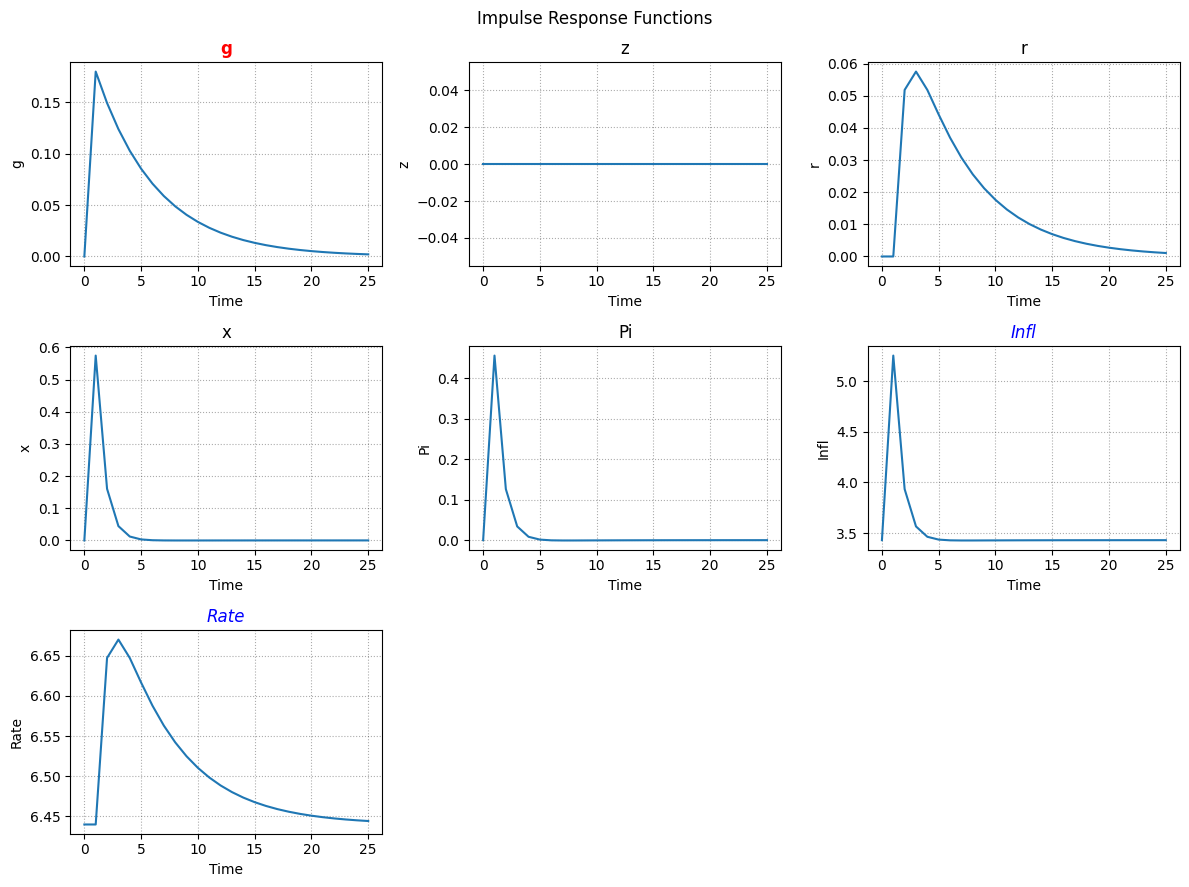

In [51]:
irf_dict = sol.irf(
    T=25,
    shocks=["g", "z"],
    scale=1.0,  # shock = sigma_var * scale
    observables=True,  # Include observables in output
)
sol.transition_plot(
    T=25,
    shocks=["g"],
    scale=1,
    observables=True,
)

In [52]:
irf_dict["z"]  # IRF paths for shock to 'z', numeric representation of the plot above

array([0.        , 0.64      , 0.54399995, 0.46239991, 0.39303989,
       0.33408388, 0.28397127, 0.24137556, 0.2051692 , 0.17439381,
       0.14823472, 0.1259995 , 0.10709957, 0.09103462, 0.07737942,
       0.0657725 , 0.05590662, 0.04752063, 0.04039253, 0.03433365,
       0.0291836 , 0.02480605, 0.02108514, 0.01792237, 0.01523401,
       0.01294891])

The plot outputs have color-coded titles to indicate the type of variable:
- **Red**: Exogenous process
- **Black**: Model Variable (State/Jump)
- **Blue**: Observable

The output above confirms that the solution is indeed well-behaved and stable as all variables converge back to steady state with clearly defined dynamics.

## 4 | Simulation with Stochastic Shocks
The `SolvedModel.sim` method allows simulating the model over a specified time horizon with stochastic shocks.
The user can define shock generators for each exogenous process, which produce shocks at each time step.
Alternatively, deterministic shocks can also be provided as a `np.ndarray`.
`SymbolicDSGE` uses the `Shock` class to facilitate the creation of various types of stochastic shocks.

If no pre-defined shocks are provided, a `Shock` object returns a shock generator that produces an array of T random shocks drawn from the specified distribution.
The distribution can be selected from "norm", "t", and "uni"; or any `SciPy` distribution that implements a `rvs` method. (formally, this requires the distribution to be a subclass of `rv_generic` from `scipy.stats._distn_infrastructure`. You can check if a given distribution meets this requirement by `isinstance(your_dist, rv_generic)` or `issubclass(your_dist, rv_generic)`.)

__NOTE:__ The shock generators use `sig_var` as the scale of the distribution. You will encounter an error if you try to pass a `scale` parameter in `dist_kwargs` when defining the shock generator.

In [53]:
T = 200
multi_shock_gen = lambda seed: Shock(
    T=T,
    dist="norm",
    multivar=True,
    seed=seed,
    dist_kwargs={
        "mean": [0.0, 0.0],
    },
).shock_generator()

uni_shock_gen = lambda seed: Shock(
    T=T,
    dist="norm",
    multivar=False,
    seed=seed,
    dist_kwargs={
        "loc": 0.0,
    },  # loc=0.0 is the default behavior, shown here for clarity.
).shock_generator()

sim_shocks = {
    "g,z": multi_shock_gen(seed=1),
    "r": uni_shock_gen(seed=2),
}  # Generate multivariate shocks for 'g' and 'z' (rho_gz != 0)
sim_data = sol.sim(
    T=T,
    x0=array([0.0, 0.0, 0.0, 0.0, 0.0], dtype=float64),  # Start at steady state
    shocks=sim_shocks,
    shock_scale=1.0,
    observables=True,
)
del sim_data["_X"]  # "_X" is a ndarray of all non-observable states for each time t.
pd.DataFrame(sim_data).head(10)  # Show first 10 rows of simulated observables data

,g,z,r,x,Pi,Infl,Rate
0,0.000000,0.000000,0.000000,0.000000,0.000000,3.430000,6.440000
1,0.011330,1.050204,-0.075016,1.012293,-0.032482,3.300072,6.139934
2,-0.205462,0.574134,-0.077463,0.100130,-0.376242,1.925032,6.130147
3,-0.492524,1.083174,-0.492503,1.969046,0.709856,6.269424,4.469987
4,-0.413906,2.050666,-0.035741,-0.091980,-1.706128,-3.394512,6.297035
5,-0.362772,1.951668,-0.548862,3.155933,0.960138,7.270553,4.244553
6,-0.541535,2.631460,-0.501924,2.633764,0.003332,3.443329,4.432303
7,-0.535652,2.037404,-0.330322,1.311612,-0.575659,1.127364,5.118713
8,-0.548409,2.476959,-0.567172,2.934051,0.366093,4.894373,4.171311
9,-0.612923,2.010941,-0.624239,2.846666,0.669537,6.108149,3.943042


In [54]:
infl = sim_data["Infl"]
rate = sim_data["Rate"]

cov = [[1, 0], [0, 1]]
noise_mat = random.multivariate_normal(mean=[0, 0], cov=cov, size=(infl.shape[0],))

infl_noise = noise_mat[:, 0]
rate_noise = noise_mat[:, 1]

infl = infl + infl_noise
rate = rate + rate_noise

y = pd.DataFrame(
    {
        "Infl": infl,
        "Rate": rate,
    }
)
kf_run = lambda mode, est, scale: sol.kalman(
    filter_mode=mode,
    observables=["Infl", "Rate"],
    y=y,
    _debug=True,
    estimate_R_diag=est,
    R_scale=scale,
)

ext = kf_run("extended", True, 1.0)
# lin = kf_run("linear", True, 1.0)

R estimation optimization successful.
Using estimated R matrix:
 [[2.99972808 0.        ]
 [0.         0.93636454]]
Log-likelihood: -890.5848683261996
_KalmanDebugInfo(A=array([[ 8.30000031e-01,  2.06977723e-18,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  8.49999922e-01,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.88029558e-01, -4.72099556e-02,  2.80184502e-01,
         0.00000000e+00,  0.00000000e+00],
       [ 8.91547192e-01,  7.07558121e-01, -1.71099245e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 6.99872131e-01, -1.15219168e-01, -1.36326405e+00,
         0.00000000e+00,  0.00000000e+00]]), B=array([[ 1.        ,  0.        ,  0.        ],
       [ 0.        ,  1.        ,  0.        ],
       [ 0.        ,  0.        ,  1.        ],
       [ 3.19330923,  0.49325041, -6.10666341],
       [ 2.53169513, -0.40579256, -4.86559405]]), C=array([[0., 0., 0., 0., 4.],
       [0., 0., 4., 0., 0.]]), d=array([3.4

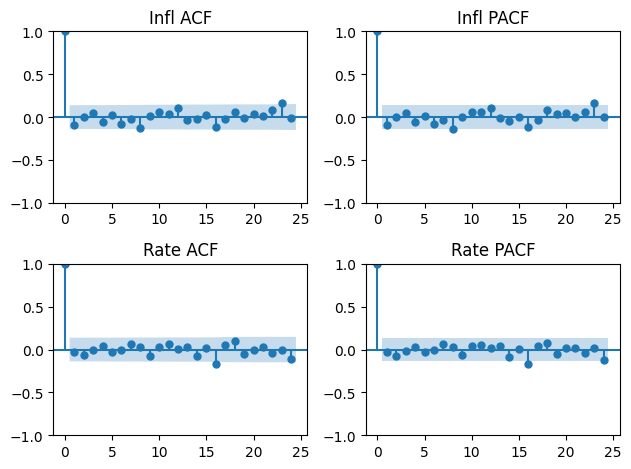

In [55]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

v = ext.innov
fig, ax = plt.subplots(2, 2)
ax = ax.flatten()

infl_innov = v[:, 0]
rate_innov = v[:, 1]

plot_acf(infl_innov, ax=ax[0])
plot_pacf(infl_innov, ax=ax[1])

plot_acf(rate_innov, ax=ax[2])
plot_pacf(rate_innov, ax=ax[3])

ax[0].set_title("Infl ACF")
ax[1].set_title("Infl PACF")
ax[2].set_title("Rate ACF")
ax[3].set_title("Rate PACF")
plt.tight_layout()

In [56]:
sol.compiled.var_names, sol.compiled.observable_names, model.equations.observable[
    "Rate"
]

(['g', 'z', 'r', 'x', 'Pi'], ['Infl', 'Rate'], pi_star + r_star + 4*r(t))

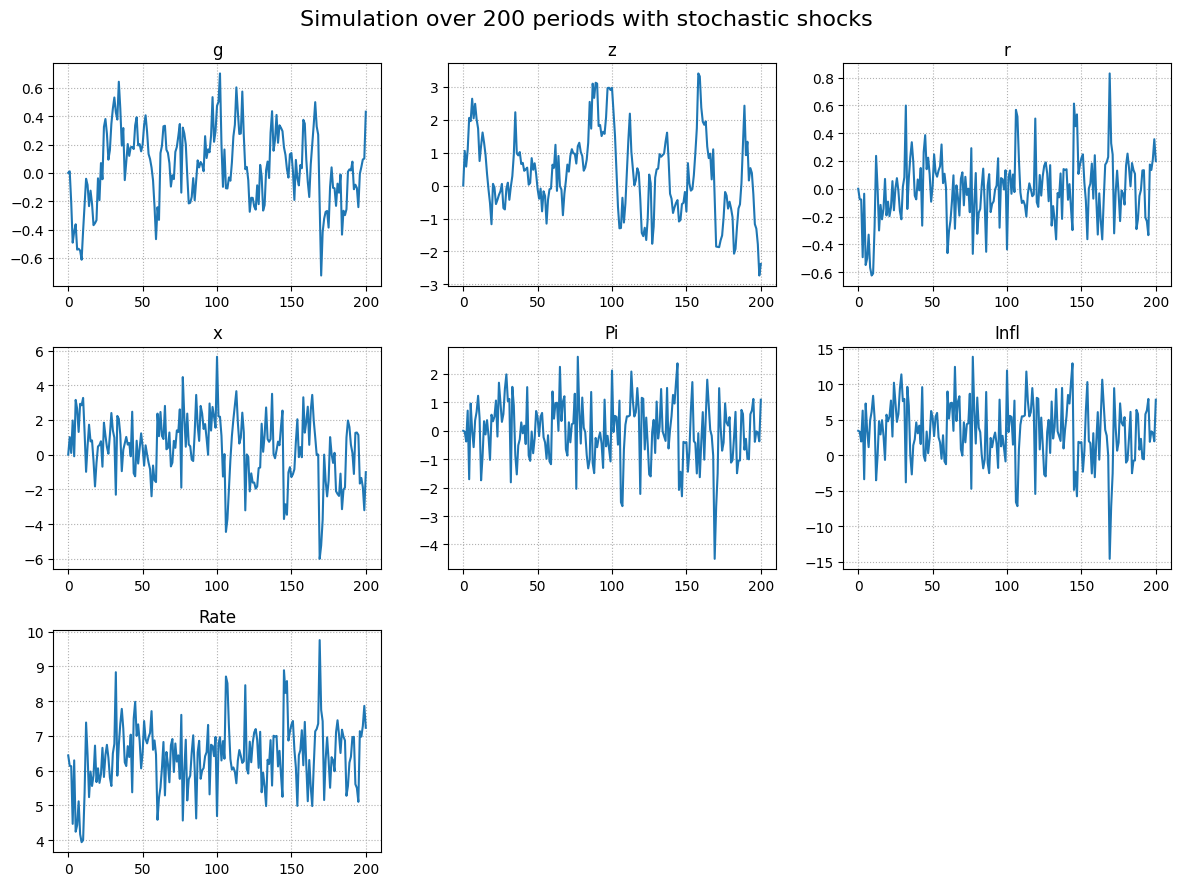

In [57]:
fig_square = ceil(sqrt(len(sim_data))).astype(int)
size = (4 * fig_square, 3 * fig_square)
fig, ax = plt.subplots(fig_square, fig_square, figsize=size)
ax = ax.flatten()

while len(ax) > len(sim_data):
    fig.delaxes(ax[-1])
    ax = ax[:-1]

for i, (var, path) in enumerate(sim_data.items()):
    ax[i].plot(path)
    ax[i].set_title(var)
    ax[i].grid(linestyle=":")
plt.suptitle(f"Simulation over {T} periods with stochastic shocks", fontsize=16)
plt.tight_layout()

## 5 | Empirical Comparison with FRED Data

The config used in this example defines calibrated parameters from a published estimation of the post-1982 US economy. (estimation period: 1960Q1 - 1998Q4)
This was specifically done to facilitate an empirical comparison of the model's simulated output with real-world data.
The `FRED` class provides a convenient interface to download and preprocess data from the Federal Reserve Economic Data (FRED) database.
The usage of `FRED` requires an API key, which can be obtained freely through FRED's website.
`SymbolicDSGE` expects the API key to either be in a pre-determined custom `env` file, or in the `.env` file in the user's working directory. (the latter is preferred by convention, but both methods work fine.)

In [58]:
fred = FRED(
    key_env=None,  # None => look for the ".env" file. If you have a custom env file, provide its path here.
    key_name="FRED_KEY",  # Name of the variable in the env file that contains the FRED API key.
)
df = fred.get_frame(
    series_ids=[
        "GDPC1",  # Real GDP
        "CPIAUCSL",  # Consumer Price Index for All Urban Consumers: All Items
        "FEDFUNDS",  # Effective Federal Funds Rate
    ],
    date_range=(
        "1955-01-01",
        "1997-10-01",
    ),  # Date range for the data ("YYYY-MM-DD" format or a pd.DatetimeIndex object)
)

gdp_q = df["GDPC1"]  # already quarterly in most pulls; verify freq

cpi_q = df["CPIAUCSL"].resample("QS").mean()  # quarterly avg CPI
ffr_q = df["FEDFUNDS"].resample("QS").mean()  # quarterly avg policy rate

idx_range = pd.date_range(start="1960-01-01", end="1997-10-01", freq="QS")


df = pd.DataFrame(
    {
        "GDPC1": gdp_q.reindex(idx_range),
        "CPIAUCSL": cpi_q.reindex(idx_range),
        "FEDFUNDS": ffr_q.reindex(idx_range),
    }
)

Data as recorded in FRED will almost never equate to model units used. Therefore, either the model should be converted to levels, or the data should be transformed to match the model's units. In practice, the latter is often preferred as a model conversion to levels must be repeated after every solution, while data transformation is a one-time task.

In this example, we use model units in linearized gaps, where steady states of any variable used are zero. However, we define "Infl" (inflation, annualized nominal) and "Rate" (interest rate, annualized nominal) as observables in the model config. If re-solving is not the main intention behind a use case, observables can be used to instantly give any model variable a representation in levels.

That said, we intend to adjust the model based on empirical performance in this case. Therefore, we will need empirical gaps in model units sooner or later.
`SymbolicDSGE` provides the `math_utils` module specifically for this purpose. Currently, `math_utils` provides:
- `HP_two_sided`: Hodrick-Prescott filter implementation for trend extraction.
- `HP_one_sided`: One-sided Hodrick-Prescott filter for real-time trend extraction.
- `annualized_log_percent`: Convert a series to annualized log percent changes.
- `detrend`: Simple detrending via a linear trend (y = mx+b, not linear regression).
- `demean`: Subtract the mean from a series.

In our model units:
- g, z: Wedge terms in their respective equations (they don't correspond to empirical observables directly)
- Output ($x$): $\ \ ln(Y_t - HP_2(Y)) \cdot 100$ [HP detrended log output gap]
- Inflation ($\Pi$): $\ \ 400 * ln(\Pi_t)$ [Annualized log inflation percent]
- Interest Rate ($r$): $\ \ 400 * ln(i_t - i^*)$ [Annualized nominal interest rate gap to steady state]

We can use the `HP_two_sided` and `annualized_log_percent` functions to convert the FRED data to model units as below.

In [59]:
x_trend = HP_two_sided(log(df["GDPC1"]), lamb=1600)[0]  # returns (trend, cycle)
x = (log(df["GDPC1"]) - x_trend) * 100  # HP detrended quarterly log output gap


inf_lvl = annualized_log_percent(df["CPIAUCSL"], periods_per_year=4)
rate_lvl = df["FEDFUNDS"]

r_ss = model.calibration.parameters["r_star"]
pi_ss = model.calibration.parameters["pi_star"]

rate = (rate_lvl - (r_ss + pi_ss)) / 4  # gap to steady state
inf = (inf_lvl - pi_ss) / 4  # gap to steady state

df_model_units = pd.DataFrame(
    {
        "r": rate,
        "Pi": inf,
        "x": x,
    }
).dropna()

observed = pd.DataFrame(
    {
        "Infl": inf_lvl[df_model_units.index],
        "Rate": rate_lvl[df_model_units.index],
    }
)
observed.index = df_model_units.index

Now that we have the data in model units, we can simulate the model over the same period and compare the results.
For the simulation state to settle, we will start with a burn-in period. As the initial state, we will use $\{g, \ z\} = \{0, \ 0\}$ and set all observables to their data point at the start of the burn-in period.

The specific calibration we're using concerns post-82, which we want to compare. Therefore, we will start the burn-in period from the furthest possible point that does not include a concrete regime change compared to 82. In our case that would be 1979Q4. (Right after Volcker's appointment as Fed Chair at 79Q3)

In [60]:
x0 = [0.0, 0.0, *df_model_units.loc["1979-10-01", :].values]
time_idx = pd.date_range(start="1979-10-01", end="1997-10-01", freq="QS")
T = len(time_idx) - 1  # -1 period because x0 is t=0

sim_data = sol.sim(
    T=T,
    x0=array(x0, dtype=float64),
    shocks={"g,z": multi_shock_gen(seed=1), "r": uni_shock_gen(seed=2)},
    shock_scale=1.0,
    observables=True,
)
observed_data = df_model_units.loc[time_idx, :]
measurement_data = observed.loc[time_idx, :]

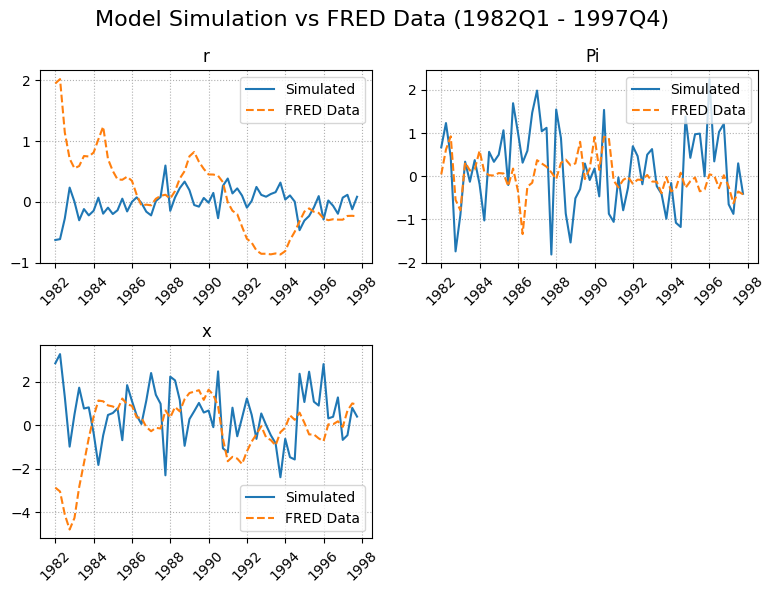

In [61]:
sim_obs = {var: sim_data[var] for var in observed_data.columns}
sim_df = pd.DataFrame(sim_obs, index=time_idx)

plot_idx = pd.date_range("1982-01-01", "1997-10-01", freq="QS")

fig_square = ceil(sqrt(len(sim_obs))).astype(int)
size = (4 * fig_square, 3 * fig_square)
fig, ax = plt.subplots(fig_square, fig_square, figsize=size)
ax = ax.flatten()

while len(ax) > len(sim_obs):
    fig.delaxes(ax[-1])
    ax = ax[:-1]

for i, var in enumerate(observed_data.columns):
    ax[i].plot(plot_idx, sim_df.loc[plot_idx, var], label="Simulated", color="C0")
    ax[i].plot(
        plot_idx,
        observed_data.loc[plot_idx, var],
        label="FRED Data",
        color="C1",
        linestyle="--",
    )
    ax[i].set_title(var)
    ax[i].grid(linestyle=":")
    ax[i].tick_params(axis="x", rotation=45)
    ax[i].legend()
plt.suptitle(f"Model Simulation vs FRED Data (1982Q1 - 1997Q4)", fontsize=16)
plt.tight_layout()

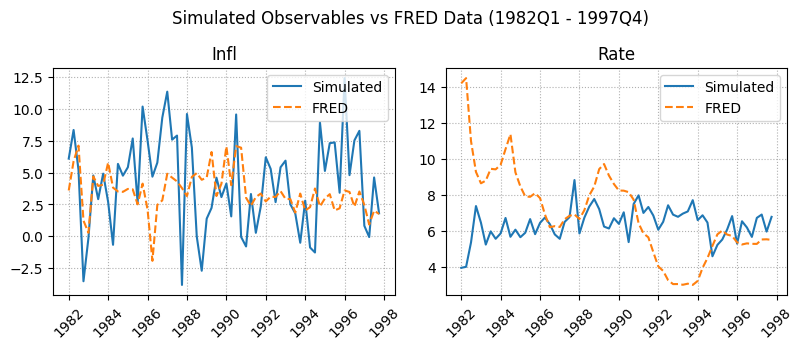

In [62]:
sim_meas_dict = {var: sim_data[var] for var in measurement_data.columns}
sim_meas = pd.DataFrame(sim_meas_dict, index=time_idx)

fig_square = ceil(sqrt(len(sim_meas_dict))).astype(int)
size = (4 * fig_square, 3 * fig_square)
fig, ax = plt.subplots(fig_square, fig_square, figsize=size)
ax = ax.flatten()
while len(ax) > len(sim_meas_dict):
    fig.delaxes(ax[-1])
    ax = ax[:-1]

for i, var in enumerate(measurement_data.columns):
    ax[i].plot(
        plot_idx,
        sim_meas.loc[plot_idx, var],
        label="Simulated",
        color="C0",
    )
    ax[i].plot(
        plot_idx,
        measurement_data.loc[plot_idx, var],
        label="FRED",
        color="C1",
        linestyle="--",
    )
    ax[i].set_title(var)
    ax[i].grid(linestyle=":")
    ax[i].tick_params(axis="x", rotation=45)
    ax[i].legend()

plt.suptitle(f"Simulated Observables vs FRED Data (1982Q1 - 1997Q4)")
plt.tight_layout()

In [63]:
meas_kf = sol.kalman(
    filter_mode="extended",
    y=measurement_data.loc[plot_idx, :],
    observables=["Infl", "Rate"],
    _debug=False,
    estimate_R_diag=True,
)

R estimation optimization successful.
Using estimated R matrix:
 [[3.23761663e-06 0.00000000e+00]
 [0.00000000e+00 8.32866830e-01]]
Log-likelihood: -275.7684446537572


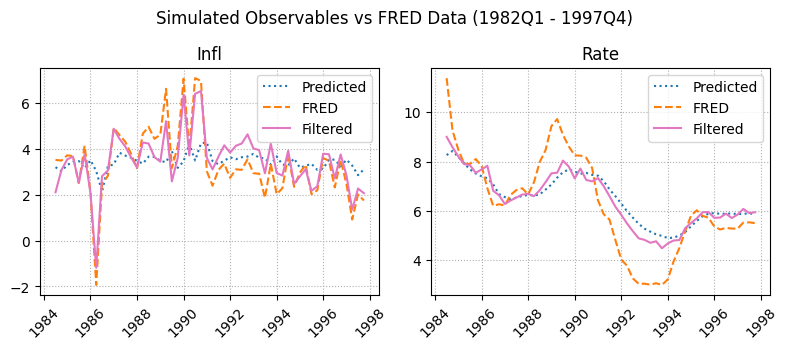

In [64]:
offset = 10
fig_square = ceil(sqrt(len(sim_meas_dict))).astype(int)
size = (4 * fig_square, 3 * fig_square)
fig, ax = plt.subplots(fig_square, fig_square, figsize=size)
ax = ax.flatten()
while len(ax) > len(sim_meas_dict):
    fig.delaxes(ax[-1])
    ax = ax[:-1]

for i, var in enumerate(measurement_data.columns):
    ax[i].plot(
        plot_idx[offset:,],
        meas_kf.y_pred[offset:, i],
        label="Predicted",
        color="C0",
        linestyle=":",
    )
    ax[i].plot(
        plot_idx[offset:,],
        measurement_data.loc[plot_idx[offset:,], var],
        label="FRED",
        color="C1",
        linestyle="--",
    )
    ax[i].plot(
        plot_idx[offset:,],
        meas_kf.y_filt[offset:, i],
        label="Filtered",
        color="C6",
    )

    ax[i].set_title(var)
    ax[i].grid(linestyle=":")
    ax[i].tick_params(axis="x", rotation=45)
    ax[i].legend()

plt.suptitle(f"Simulated Observables vs FRED Data (1982Q1 - 1997Q4)")
plt.tight_layout()

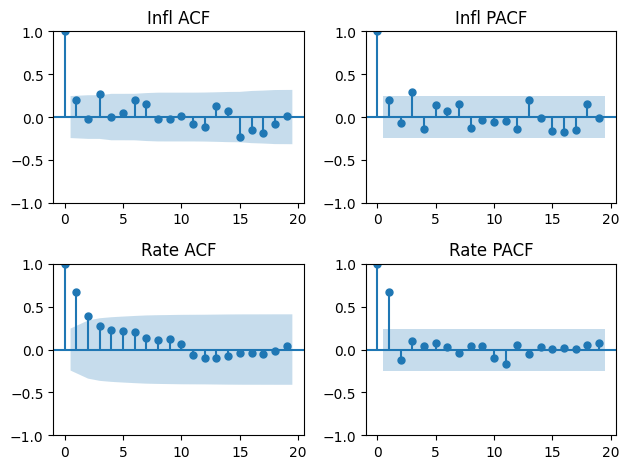

In [65]:
v_meas = meas_kf.innov
fig, ax = plt.subplots(2, 2)
ax = ax.flatten()

infl_innov_meas = v_meas[:, 0]
rate_innov_meas = v_meas[:, 1]

plot_acf(infl_innov_meas, ax=ax[0])
plot_pacf(infl_innov_meas, ax=ax[1])

plot_acf(rate_innov_meas, ax=ax[2])
plot_pacf(rate_innov_meas, ax=ax[3])

ax[0].set_title("Infl ACF")
ax[1].set_title("Infl PACF")
ax[2].set_title("Rate ACF")
ax[3].set_title("Rate PACF")
plt.tight_layout()

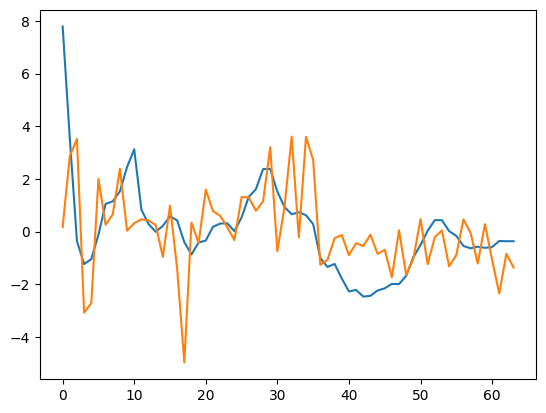

In [66]:
plt.plot(rate_innov_meas)
plt.plot(infl_innov_meas)

In [67]:
template = TemplateConfig(
    power_law_lower_bound=2,
    power_law_upper_bound=2,
    powers_in_interactions=True,
    poly_interaction_order=2,
    interaction_form="prod",
    include_expression=False,
    hessian_restriction="free",
)
params = PySRParams(
    precision=32,
    niterations=300,
    binary_operators=["+", "-", "*", "/"],
    complexity_of_constants=2,
    maxsize=12,
    deterministic=True,
    parallelism="serial",
    random_state=0,
    should_optimize_constants=True,
    should_simplify=True,
)

parametrizer = ModelParametrizer(
    config=template,
    params=params,
    variable_names=model.variables[2:],
)

parametrizer.make_and_add_template(expr=model.equations.observable["Rate"])
sr = SymbolicRegressor(parametrizer)

In [68]:
sr.fit(meas_kf.x_pred[:, 2:], rate_innov_meas, variable_names=model.variables[2:])

C:\Users\guney\miniconda3\envs\sdsge-test\Lib\site-packages\pysr\sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 1.870e+05
Progress: 1113 / 9300 total iterations (11.968%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.714e+00  0.000e+00  f_1 = #1
2           2.708e+00  2.111e-03  f_1 = 0.036833
3           2.607e+00  3.796e-02  f_1 = #1 - #4
5           2.594e+00  2.524e-03  f_1 = (#1 - #4) - #3
6           2.453e+00  5.577e-02  f_1 = #4 / (#1 + -1.2205)
8           2.443e+00  2.030e-03  f_1 = #4 / (#4 + (#1 + -1.4513))
9           2.435e+00  3.288e-03  f_1 = (#4 / (#1 + -1.2162)) + 0.13601
10          2.435e+00  1.650e-04  f_1 = (#4 / ((#1 + -1.1735) - #5)) - #5
11          2.391e+00  1.805e-02  f_1 = ((#4 / (#1 + -1.2185)) - #4) + 0.31198
───────────────────────────────────────────────────────────────────────────────────────────────────
═══════════════

[ Info: Final population:
[ Info: Results saved to:


complexity                                                          9
loss                                                         2.241947
equation                          x**2/(r*x - 0.0045637866) + 1.44191
score                                                        0.086066
julia_expression         f_1 = (#4 / (#2 + -0.0045637866)) - -1.44191
lambda_format       <pysr.expression_specs.CallableJuliaExpression...
sympy_format                      x**2/(r*x - 0.0045637866) + 1.44191
initial_expr                      x**2/(r*x - 0.0045637866) + 1.44191
Name: 6, dtype: object

  - C:\\Users\\guney\\AppData\\Local\\Temp\\tmp9x05ewx8\20260223_025830_BX7eKA\hall_of_fame.csv


In [69]:
sr.classify_expressions(sr.model.equations_).top_candidates

,complexity,loss,equation,score,julia_expression,lambda_format,sympy_format,initial_expr,loss,complexity,constant_count,total
4,6,2.453417,x**2/(r**2 - 1.2204587),0.055770,f_1 = #4 / (#1 + -1.2204587),<pysr.expression_specs.CallableJuliaExpression...,x**2/(r**2 - 1.2204587),x**2/(r**2 - 1.2204587),5.320744e-01,0.5,1.0,2.032074
2,3,2.607262,r**2 - x**2,0.037959,f_1 = #1 - #4,<pysr.expression_specs.CallableJuliaExpression...,r**2 - x**2,r**2 - x**2,2.177705e-01,0.8,1.0,2.017771
0,1,2.713855,r**2,0.000000,f_1 = #1,<pysr.expression_specs.CallableJuliaExpression...,r**2,r**2,2.042998e-08,1.0,1.0,2.000000
5,8,2.443450,x**2/(r**2 + x**2 - 1.4520763),0.002035,f_1 = #4 / ((#1 + #4) + -1.4520763),<pysr.expression_specs.CallableJuliaExpression...,x**2/(r**2 + x**2 - 1.4520763),x**2/(r**2 + x**2 - 1.4520763),5.524371e-01,0.3,1.0,1.852437
3,5,2.594132,-Pi*r + r**2 - x**2,0.002524,f_1 = (#1 - #4) - #3,<pysr.expression_specs.CallableJuliaExpression...,-Pi*r + r**2 - x**2,-Pi*r + r**2 - x**2,2.445941e-01,0.6,1.0,1.844594
